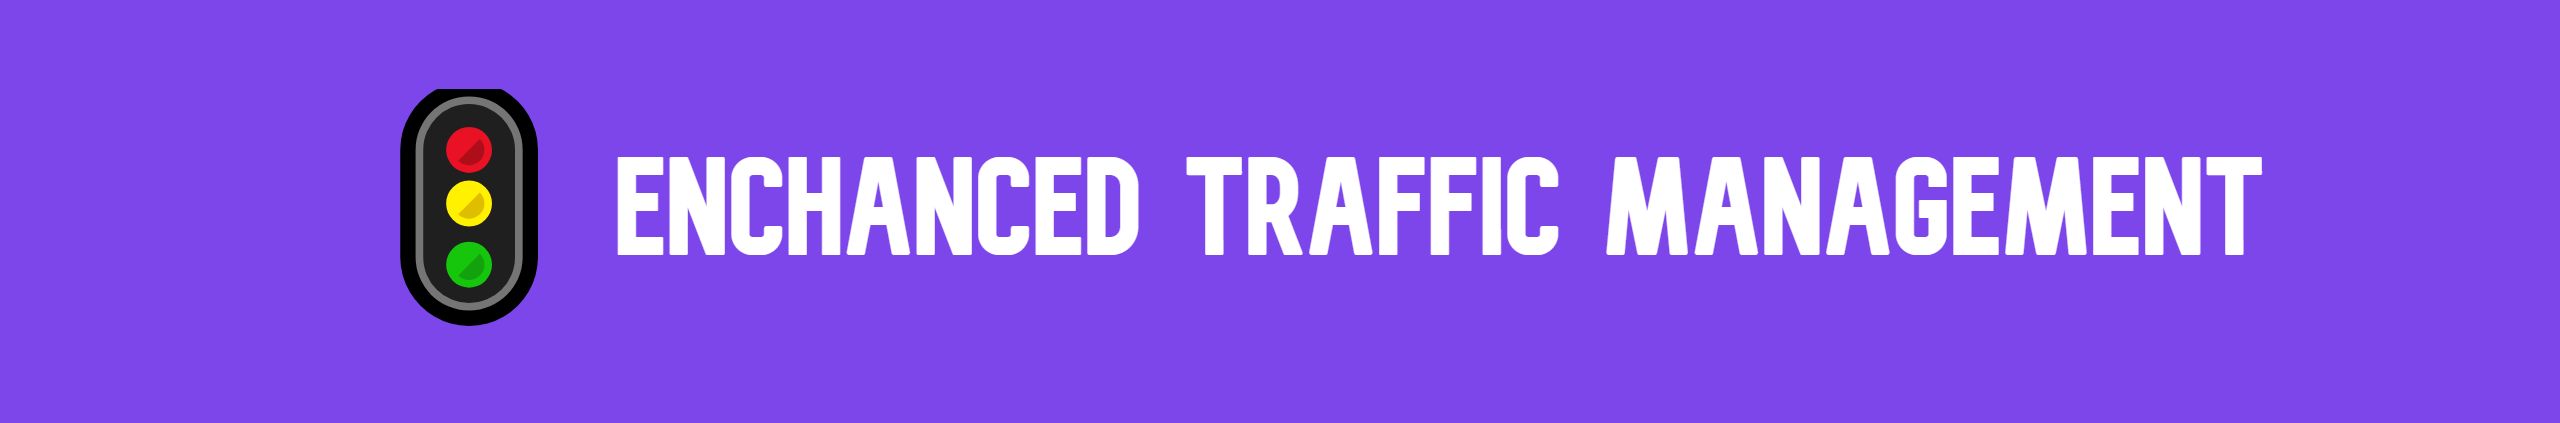

# 📚 About Project
This project aims to use AI to manage traffic more efficiently that's made for a school exhibition.
#### 📦 __Resources Used__
- Ultralytics
- Supervision
- Socket.io Client (Python)


# 📢 Idea About The Workings
This project takes image frames from a webcame and run inferences on cloud and pass the detections to websocket server. The websocket server is hosted on an Raspberry pi which then uses an algorithm to control traffic lights according to lane density and during emergencies for the vehicles to pass efficiently without congesting.

This project uses the concept of YOLO (You-Only-Look-Once) to predict these type of inputs.

**Note:** All these are for school project and are not really optimized for production in real life. Consider editing and optimizing the code for specific deployements.
#### 📡 Communications:
- Webcame < -- > Cloud < -- > Websocket Server


#### ✨ Visualise Here
- [Microsoft Whiteboard Image](https://github.com/Nishant1500/school-idk/blob/main/AI%20Project%202023-24%20(1).png?raw=true)


## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

In [ ]:
import cv2
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data


## Install Ultralytics

In [ ]:
!pip install ultralytics
!pip install "python-socketio[client]"

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

## Install Roboflow Supervision

In [ ]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

## Load pre-trained model

In [ ]:
from ultralytics import YOLO

model = YOLO("best.pt")
model.to('cuda')
model.fuse()

## Predict and annotate single frame

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

print(CLASS_NAMES_DICT)
# class_ids of interest - car, motorcycle, bus and truck
selected_classes = [2, 3, 5, 7]

In [ ]:
import supervision as sv
import numpy as np
from google.colab.output import eval_js
from base64 import b64decode, b64encode

def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [ ]:
from IPython.display import display, Javascript, Image
from IPython.display import clear_output
import time
from io import BytesIO
from PIL import Image
import base64
import sys
from supervision import Position
import socketio

WEBSOCKET_URL = "https://7ae2-2409-40e2-b-bba2-6dde-dede-b265-6fb5.ngrok-free.app"

video_stream()

sio = socketio.Client();

bbox = ""

js_reply = video_frame("Capturing..", bbox)

# ZONE_IN_POLYGON = np.array([[209, 113], [388, 108], [394, 292], [188, 296]])
ZONE_1 = np.array([[1,278], [300,278], [300,398], [1,398]])
ZONE_2 = np.array([[374,398], [374,278], [638,278], [638,398]])
ZONE_3 = np.array([[269,278], [410,278],  [410,7], [269,7]])

count=0
# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)

while True:
  if sio.connected:
    break
  print("Connecting")
  try:
    sio.connect(WEBSOCKET_URL)
  except:
    the_type, the_value, the_traceback = sys.exc_info()
    print(the_type, the_value, the_traceback);


while True:
  if not js_reply:
        break

  # convert JS response to OpenCV Image

  js_reply = video_frame("Capturing..", bbox)
  frame = js_to_image(js_reply["img"])

  # frame = cv2.imread("test4.jpeg")

  """
  img22 = Image.fromarray(frame)
  width, height = img22.size
  """
  height = np.size(frame, 0)
  width = np.size(frame, 1)
  # model prediction on single frame and conversion to supervision Detections
  results = model(frame, verbose=False, device=0)[0]
  # convert to Detections
  detections = sv.Detections.from_ultralytics(results)
  # only consider class id from selected_classes define above
  # detections = detections[np.isin(detections.class_id, selected_classes)]

  # format custom labels
  zone1 = sv.PolygonZone(
            polygon=ZONE_1,
            frame_resolution_wh=(width, height),
            triggering_position=Position.CENTER,
        )
  zone2 = sv.PolygonZone(
            polygon=ZONE_2,
            frame_resolution_wh=(width, height),
            triggering_position=Position.CENTER,
        )
  zone3 = sv.PolygonZone(
            polygon=ZONE_3,
            frame_resolution_wh=(width, height),
            triggering_position=Position.CENTER,
        )

  bounding_box_annotator = sv.BoundingBoxAnnotator()
  label_annotator = sv.LabelAnnotator()
  zone1_annotator = sv.PolygonZoneAnnotator(zone=zone1, color=sv.ColorPalette.default().by_idx(1))
  zone2_annotator = sv.PolygonZoneAnnotator(zone=zone2, color=sv.ColorPalette.default().by_idx(1))
  zone3_annotator = sv.PolygonZoneAnnotator(zone=zone3, color=sv.ColorPalette.default().by_idx(1))

  labels = [
      results.names[class_id]
      for class_id
      in detections.class_id
  ]

  in_zone1_detections = detections[zone1.trigger(detections=detections)]
  in_zone2_detections = detections[zone2.trigger(detections=detections)]
  in_zone3_detections = detections[zone3.trigger(detections=detections)]

  ambulance_in_zone1 = in_zone1_detections[np.isin(in_zone1_detections.class_id, [0])]
  ambulance_in_zone2 = in_zone2_detections[np.isin(in_zone2_detections.class_id, [0])]
  ambulance_in_zone3 = in_zone3_detections[np.isin(in_zone3_detections.class_id, [0])]

  ambulance_zones=[]
  if(ambulance_in_zone1.__len__() > 0): ambulance_zones.append(1)
  if(ambulance_in_zone2.__len__() > 0): ambulance_zones.append(2)
  if(ambulance_in_zone3.__len__() > 0): ambulance_zones.append(3)

  annotated_image = bounding_box_annotator.annotate(
      scene=frame, detections=detections)
  annotated_image = label_annotator.annotate(
     scene=annotated_image, detections=detections, labels=labels)
  annotated_image = zone1_annotator.annotate(
      scene=annotated_image, label=f"Vehicle Found: {zone1.current_count}")
  annotated_image = zone2_annotator.annotate(
      scene=annotated_image, label=f"Vehicle Found: {zone2.current_count}")
  annotated_image = zone3_annotator.annotate(
      scene=annotated_image, label=f"Vehicle Found: {zone3.current_count}")

  ain = Image.fromarray(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
  buffered = BytesIO()
  ain.save(buffered, format="JPEG")
  img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")

  sio.emit('inference', {
      "img": img_str,
      "zone_1": zone1.current_count,
      "zone_2": zone2.current_count,
      "zone_3": zone3.current_count,
      "ambulance_zones": ambulance_zones
      })

  %matplotlib inline
  sv.plot_image(annotated_image, (8,8))

  time.sleep(2)

# Debug
This section is for debug purposes.

In [ ]:
!wget https://images.pexels.com/photos/1609443/pexels-photo-1609443.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1

In [ ]:
import pycuda
from pycuda import compiler
import pycuda.driver as drv
import torch

drv.init()
print("%d device(s) found." % drv.Device.count())

for ordinal in range(drv.Device.count()):
    dev = drv.Device(ordinal)
    print (ordinal, dev.name())

torch.cuda.current_device()

In [ ]:
model.export(format="tflite")

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8x.pt')

# Train the model
results = model.train(data='data.yaml', project="Traffic", epochs=100, device=0, val=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp drive/MyDrive/AI_Project/best.pt ./

In [ ]:
!gdown -O "best.pt" "https://drive.google.com/uc?id=1bO0KjloHSenWbDRzX84gvLdf9dduR3iM"

In [ ]:
!cp -R Traffic/train2/ drive/MyDrive/AI_Project/

In [ ]:
!gdown -O "traffic.pt" "https://drive.google.com/uc?id=1y-IfToCjRXa3ZdC1JpnKRopC7mcQW-5z"

In [ ]:
from IPython.display import HTML
js11=HTML("""
 <script src="https://cdn.socket.io/4.6.0/socket.io.min.js" integrity="sha384-c79GN5VsunZvi+Q/WObgk2in0CbZsHnjEqvFxC5DxHn9lTfNce2WW6h2pH6u/kF+" crossorigin="anonymous"></script>
 <script>
  const socket12 = io("http://127.0.0.1:3000");


  socket12.on("connect", () => {
    console.log(socket12.id); // x8WIv7-mJelg7on_ALbx
  });

  socket12.on("disconnect", () => {
    console.log(socket12.id); // undefined
  });

  socket12.on("hello" , (...data) => {
    console.log(data)
  });
 </script>
""")

display(js11);

In [ ]:
!pip install "python-socketio[asyncio_client]"

In [ ]:
import socketio

sio = socketio.AsyncClient();
await sio.connect('https://3bb1-2409-40e2-b-184b-d871-a4ec-666f-9ddc.ngrok-free.app')

await sio.emit('hello', {'foo': 'bar'})

list = await sio.receive()
@sio.on('world')
def world(data):
    print('I received a message!', data)

https://drive.google.com/uc?id=1y-IfToCjRXa3ZdC1JpnKRopC7mcQW-5z